In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [23]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import hemcee
import tfmodeling as tfm

import rvhmc

session = tf.InteractiveSession()

In [24]:
np.random.seed(1234)

N_pl = 2

T = tf.float64

# Data
t = np.sort(np.random.uniform(0, 365.0, 150))
yerr = np.random.uniform(1, 5, len(t))
y = yerr * np.random.randn(len(t))
t_tensor = tf.placeholder(T, name="t")
feed_dict = {t_tensor: t}

# Parameters
lk = np.log(np.random.uniform(5, 15, N_pl))
lk[0] = -4
log_K = tfm.Parameter(lk, bounds=(-10, 10), name="log_K", dtype=T)
log_P = tfm.Parameter(np.random.uniform(np.log(5), np.log(50), N_pl), bounds=(np.log(5), np.log(100)), name="log_P", dtype=T)
omega_vec = tfm.UnitVector(np.random.randn(N_pl, 2), name="omega_vec", dtype=T)
e = tfm.Parameter(np.random.uniform(0, 0.1, N_pl), bounds=(0, 1), name="e", dtype=T)
phi_vec = tfm.UnitVector(np.random.randn(N_pl, 2), name="phi_vec", dtype=T)
rv0 = tfm.Parameter(0.0, bounds=(-500, 500), name="rv0", dtype=T)
log_jitter = tfm.Parameter(-10, bounds=(-15, 0.0), name="log_jitter", dtype=T)

# Parameter transformations
K = tf.exp(log_K.value)
P = tf.exp(log_P.value)
sin_omega = omega_vec.value[:, 0]
cos_omega = omega_vec.value[:, 1]
omega = tf.atan2(sin_omega, cos_omega)
phi = tf.atan2(phi_vec.value[:, 0], phi_vec.value[:, 1])
jitter2 = tf.exp(2*log_jitter.value)

# The RV model
n = 2.0 * np.pi / P
t0 = (phi + omega) / n
M = n * t_tensor[:, None] - (phi + omega)
E = rvhmc.kepler(M, e.value + tf.zeros_like(M))
f = 2*tf.atan2(tf.sqrt(1+e.value)*tf.tan(0.5*E), tf.sqrt(1-e.value)+tf.zeros_like(E))
rv_models = K * (cos_omega*(tf.cos(f)+e.value) - sin_omega*tf.sin(f))

# Sum the contributions from each planet
rv = rv0.value + tf.reduce_sum(rv_models, axis=1)

session.run(tf.global_variables_initializer())

# Simulate the data
y += rv.eval(feed_dict=feed_dict)

# Compute the likelihood
yerr2 = yerr**2
log_like = -0.5 * tf.reduce_sum(
    tf.square(y - rv) / (yerr2 + jitter2) + tf.log(yerr2 + jitter2)
)

model = tfm.Model(log_like, [log_K, log_P, omega_vec, e, phi_vec, rv0, log_jitter], feed_dict={t_tensor: t})
true_params = model.current_vector()

opt = tf.contrib.opt.ScipyOptimizerInterface(-model.target, model.get_parameters())

In [27]:
vec = model.current_vector()
model.value(vec)

K = 500
strt = time.time()
for k in range(K):
    model.value(vec)
print((time.time() - strt) / K)

0.0007946305274963379


In [28]:
vec = model.current_vector()
model.gradient(vec)

K = 500
strt = time.time()
for k in range(K):
    model.gradient(vec)
print((time.time() - strt) / K)

0.0013927063941955567


In [4]:
tf.gradients(model.target, model.get_parameters())[0].eval(feed_dict=feed_dict)

array([ 6.55502726e-02, -1.18506640e+02])

In [5]:
print(session.run(model.get_parameters()))
opt.minimize(session, feed_dict={t_tensor: t})
print(session.run(model.get_parameters()))

[array([-0.84729786,  0.34918832]), array([-3.67311713, -1.4739852 ]), array([[-0.22663229, -0.92383072],
       [ 0.355839  , -1.27006348]]), array([-2.30935605, -2.23404955]), array([[-0.19547241, -0.4634194 ],
       [ 0.98941485,  1.38864738]]), 0.0, -0.6931471805599456]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 204.770194
  Number of iterations: 130
  Number of functions evaluations: 282
[array([-0.62799846,  0.34240382]), array([-2.23126538, -1.47459637]), array([[ 0.01622809,  0.01633444],
       [ 0.01956111, -0.06975811]]), array([-1.2934416, -2.9424377]), array([[-6.78054429e-03, -1.68207815e-02],
       [ 1.01540959e-05,  1.37690617e-05]]), 0.0007360697534002423, -0.3046701484861846]


In [6]:
metric = hemcee.metric.DenseMetric(np.eye(len(model.current_vector())))
sampler = hemcee.NoUTurnSampler(model.value, model.gradient, metric=metric)

In [7]:
q, lp = sampler.run_warmup(model.current_vector(), 10000, final_buffer=1000)

initial warm up: step_size: 2.0e-03; mean(accept_stat): 0.458: 100%|██████████| 100/100 [00:05<00:00, 19.84it/s]
warm up 1/9: step_size: 1.0e-03; mean(accept_stat): 0.505: 100%|██████████| 25/25 [00:01<00:00, 17.65it/s]
warm up 2/9: step_size: 4.8e-02; mean(accept_stat): 0.465: 100%|██████████| 25/25 [00:01<00:00, 23.80it/s]
warm up 3/9: step_size: 1.5e-01; mean(accept_stat): 0.470: 100%|██████████| 50/50 [00:02<00:00, 24.05it/s]
warm up 4/9: step_size: 2.4e-01; mean(accept_stat): 0.485: 100%|██████████| 100/100 [00:04<00:00, 21.35it/s]
warm up 5/9: step_size: 1.1e-01; mean(accept_stat): 0.488: 100%|██████████| 200/200 [00:10<00:00, 18.81it/s]
warm up 6/9: step_size: 2.1e-01; mean(accept_stat): 0.493: 100%|██████████| 400/400 [00:26<00:00, 15.08it/s]
warm up 7/9: step_size: 2.6e-01; mean(accept_stat): 0.496: 100%|██████████| 800/800 [00:50<00:00, 15.96it/s]
warm up 8/9: step_size: 8.6e-03; mean(accept_stat): 0.494: 100%|██████████| 1600/1600 [01:48<00:00, 14.71it/s]
warm up 9/9: step_s

In [8]:
nuts = sampler.run_mcmc(q, 10000)

step_size: 1.2e-02; mean(accept_stat): 0.679: 100%|██████████| 10000/10000 [12:03<00:00, 13.83it/s]


In [9]:
chain, lp_chain = nuts

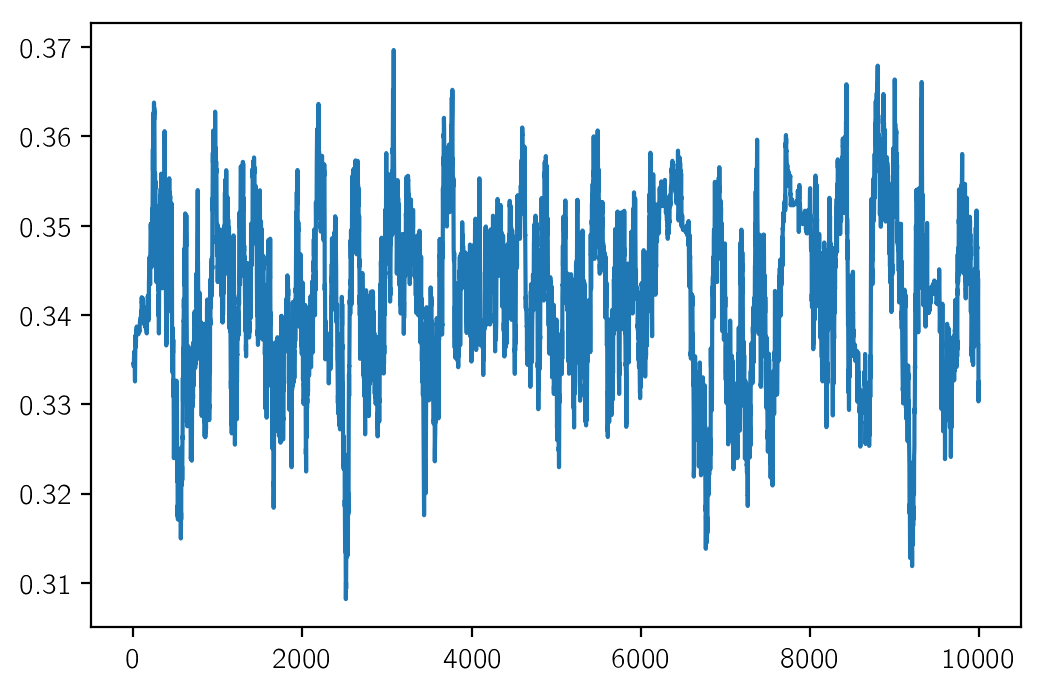

In [10]:
plt.plot(chain[:, 1]);

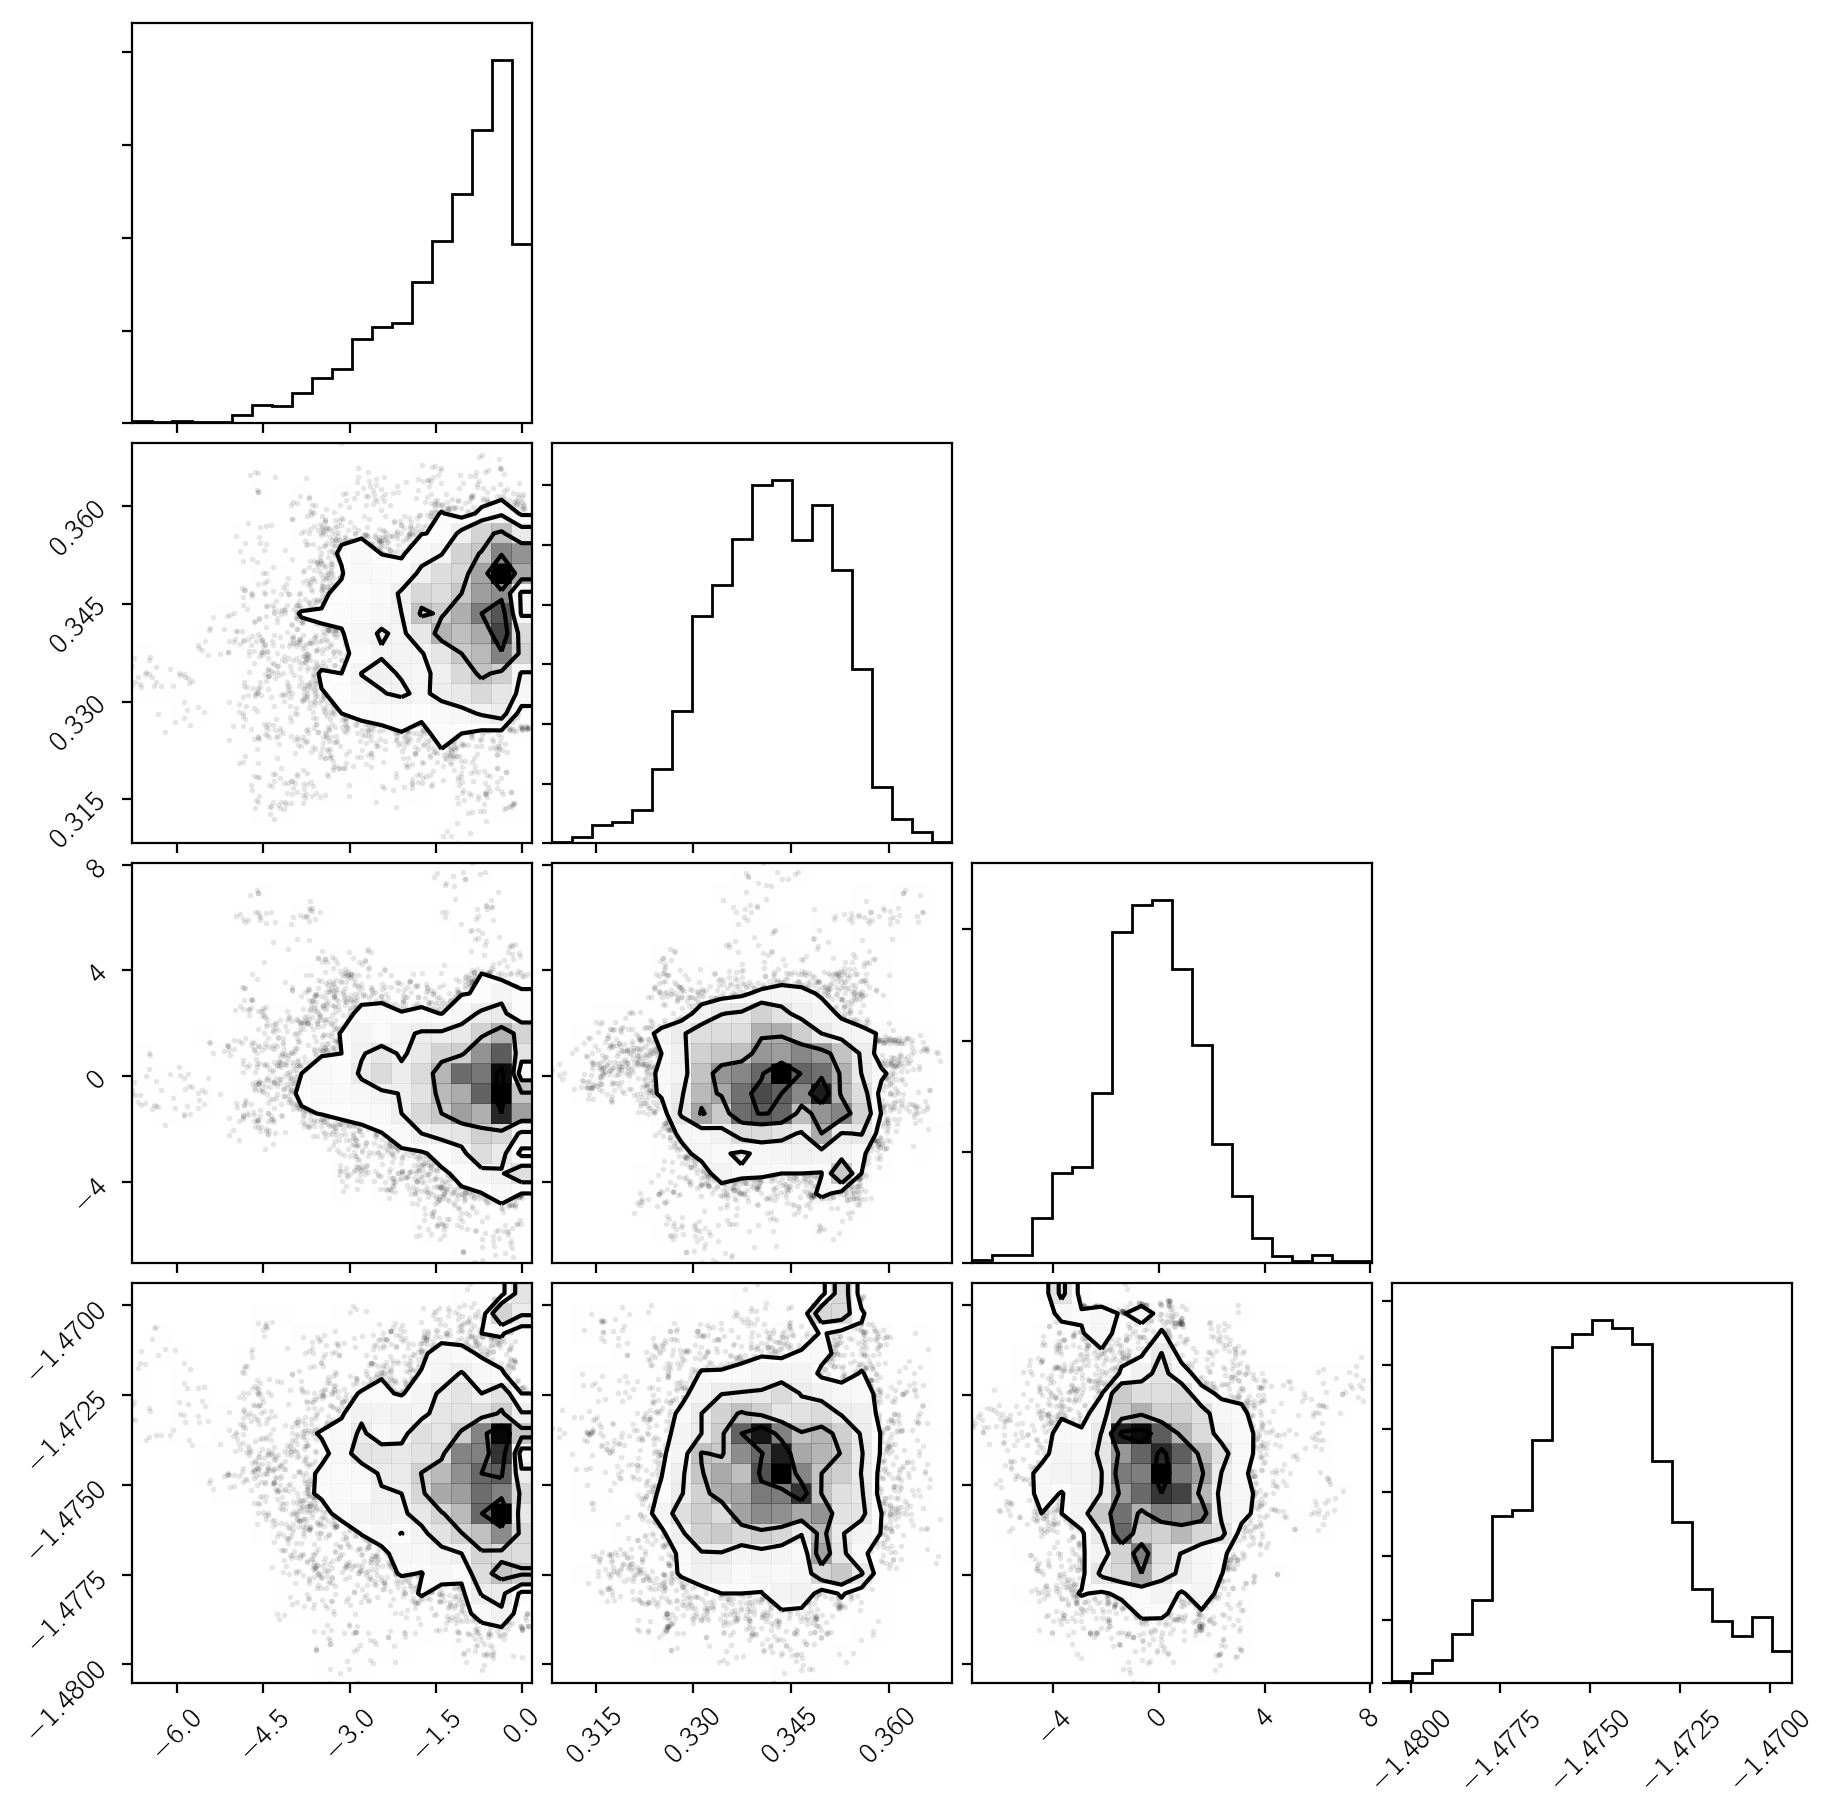

In [11]:
import corner
corner.corner(chain[:, :2*N_pl]);

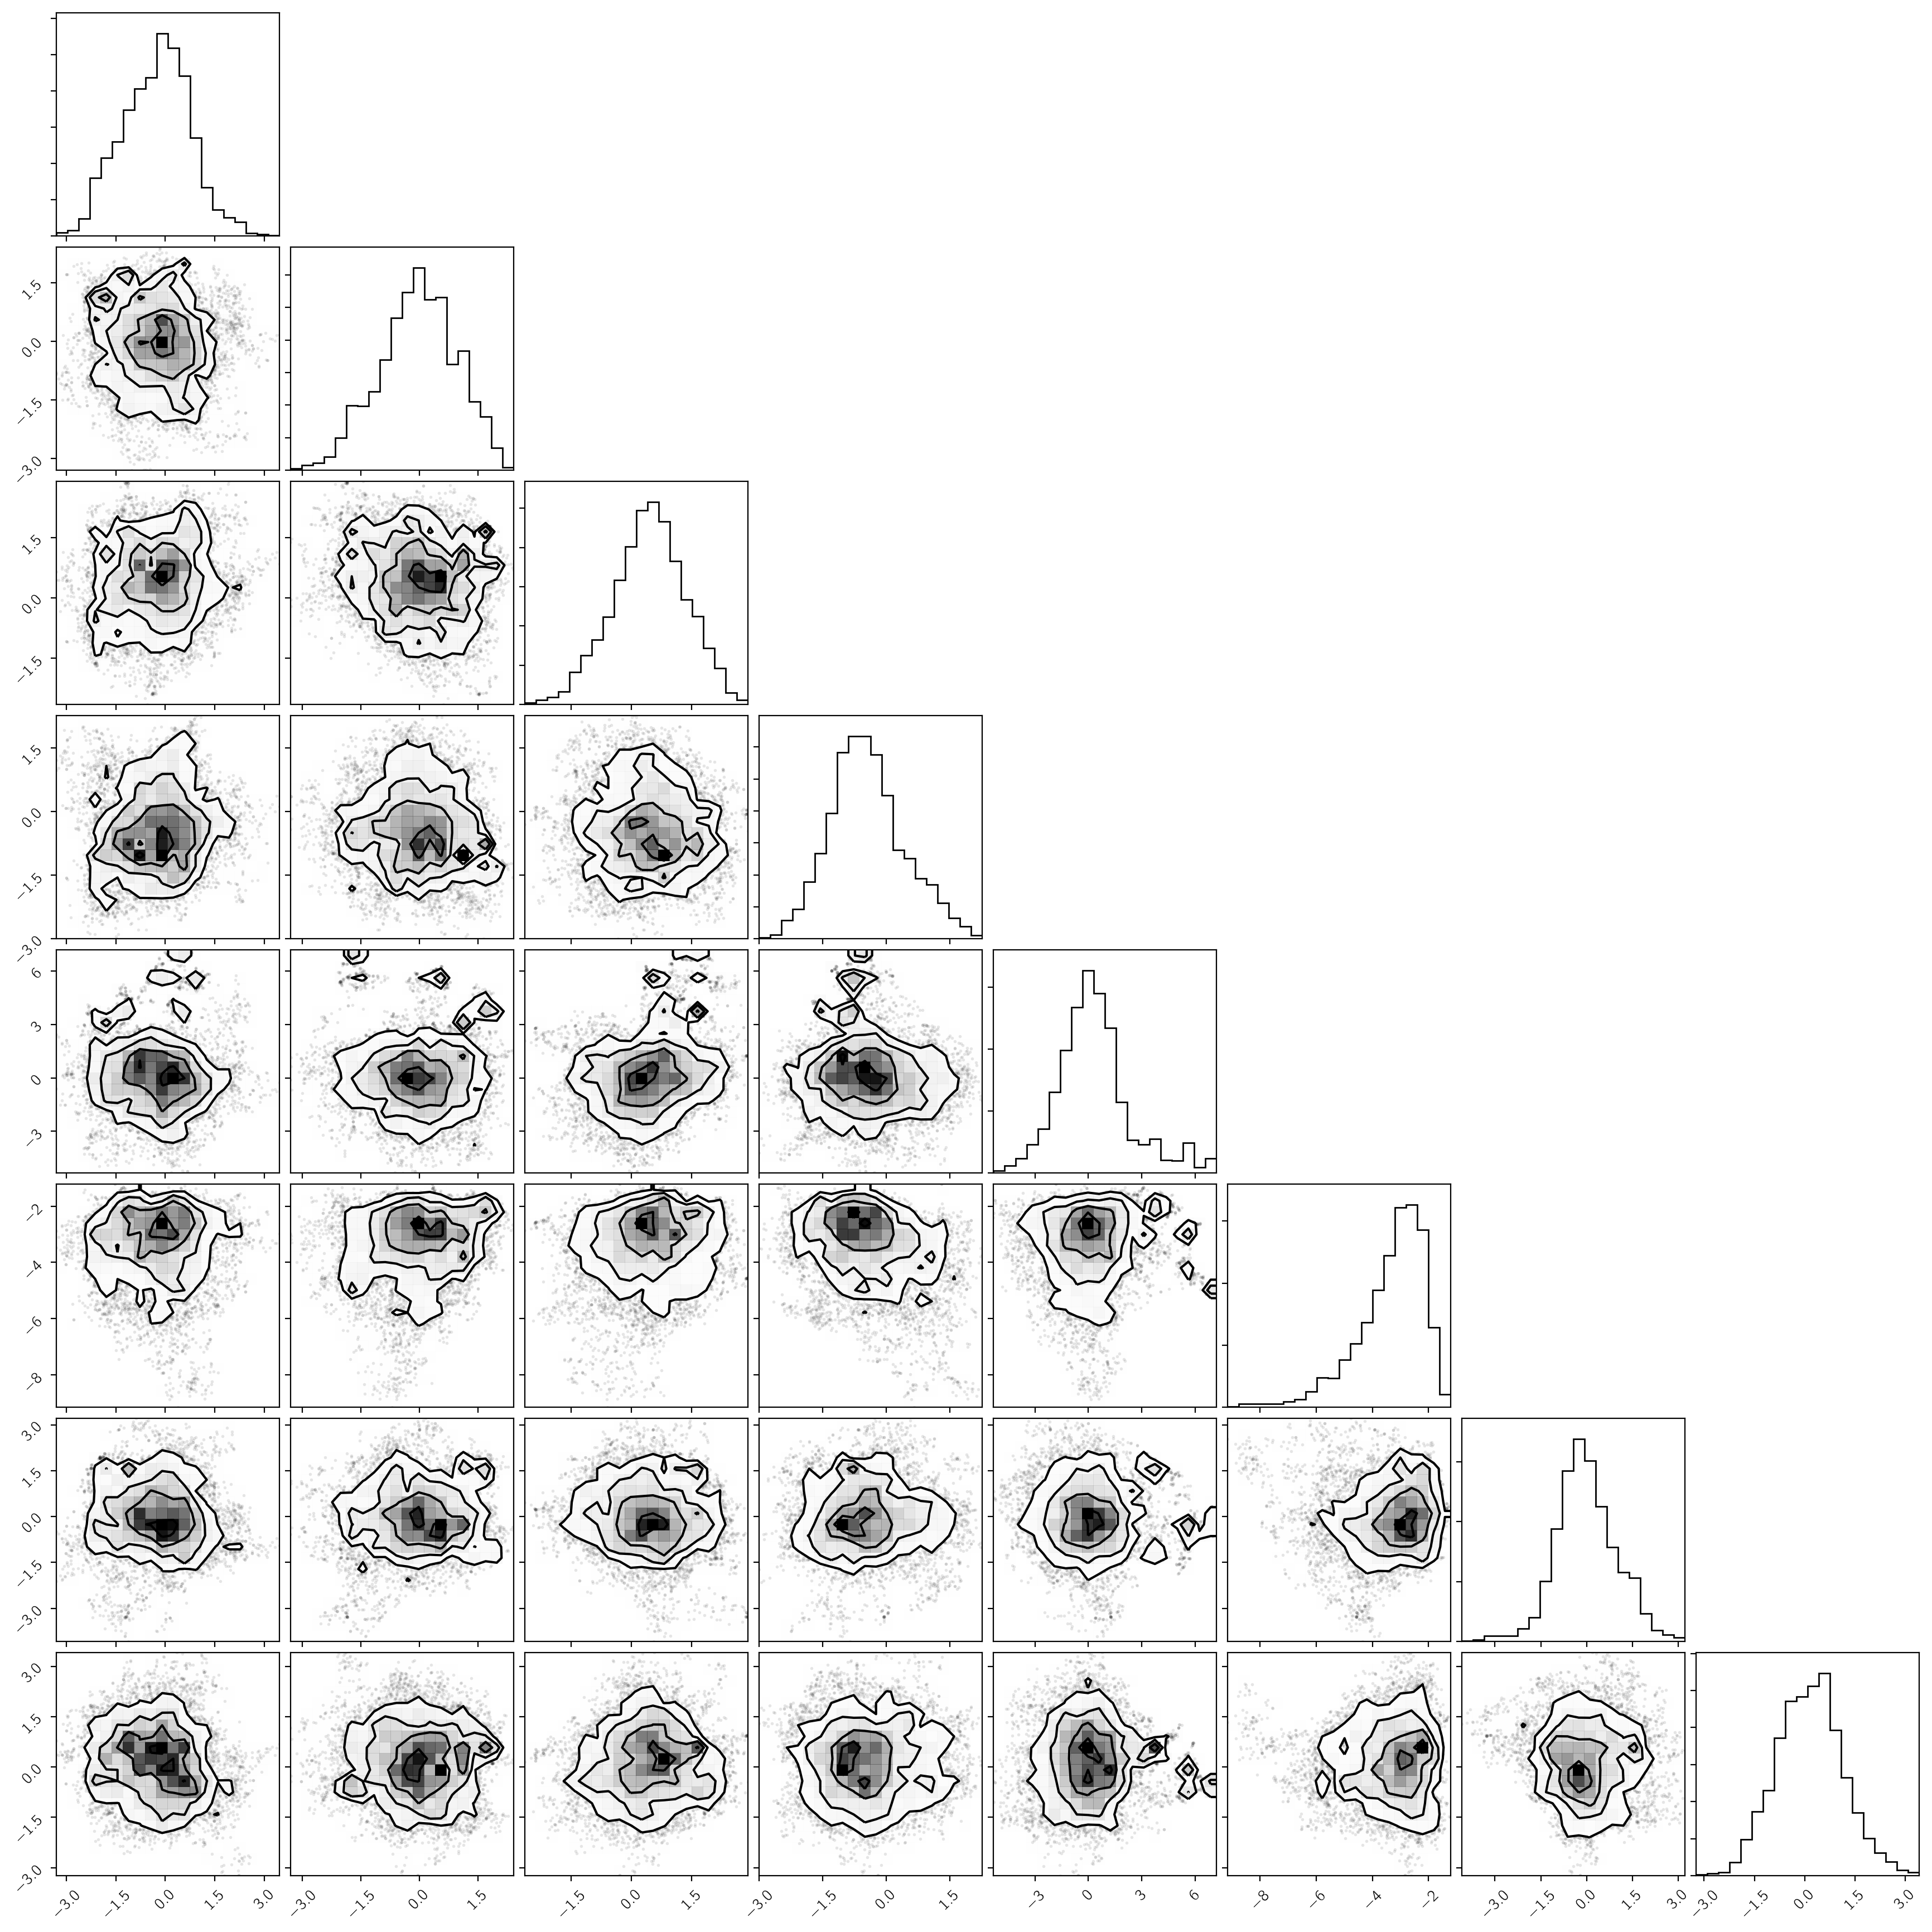

In [12]:
corner.corner(chain[:, 2*N_pl:6*N_pl]);

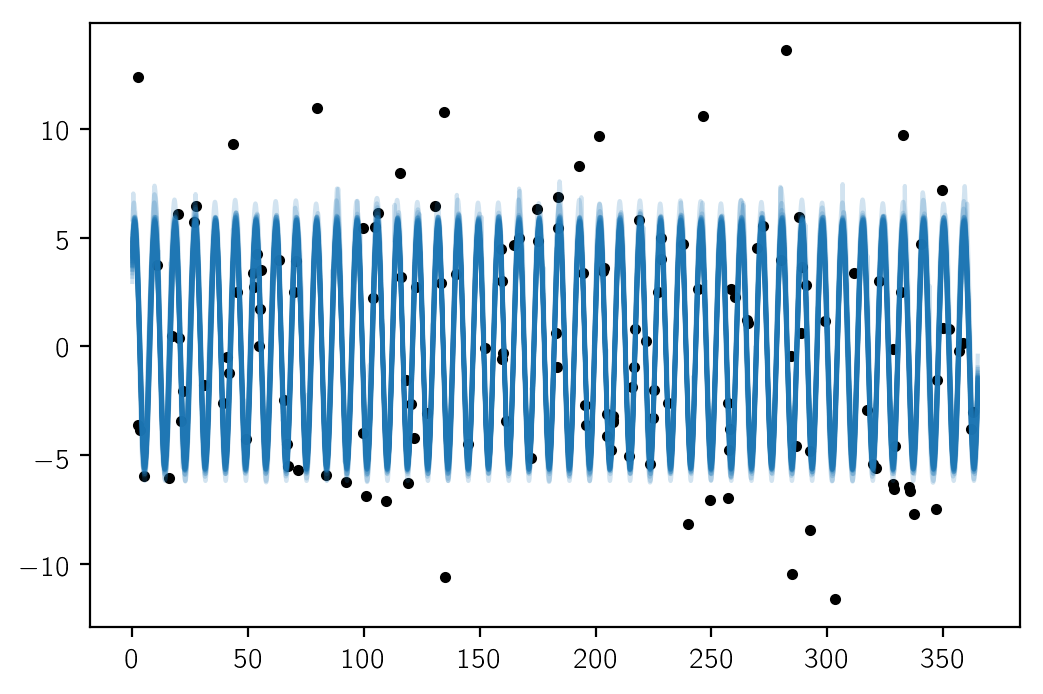

In [13]:
plt.plot(t, y, ".k")

x = np.linspace(0, 365, 5000)
for s in chain[np.random.randint(len(chain), size=50)]:
    fd = model.vector_to_feed_dict(s)
    fd[t_tensor] = x
    mod = rv.eval(feed_dict=fd)
    plt.plot(x, mod, color="C0", alpha=0.2)

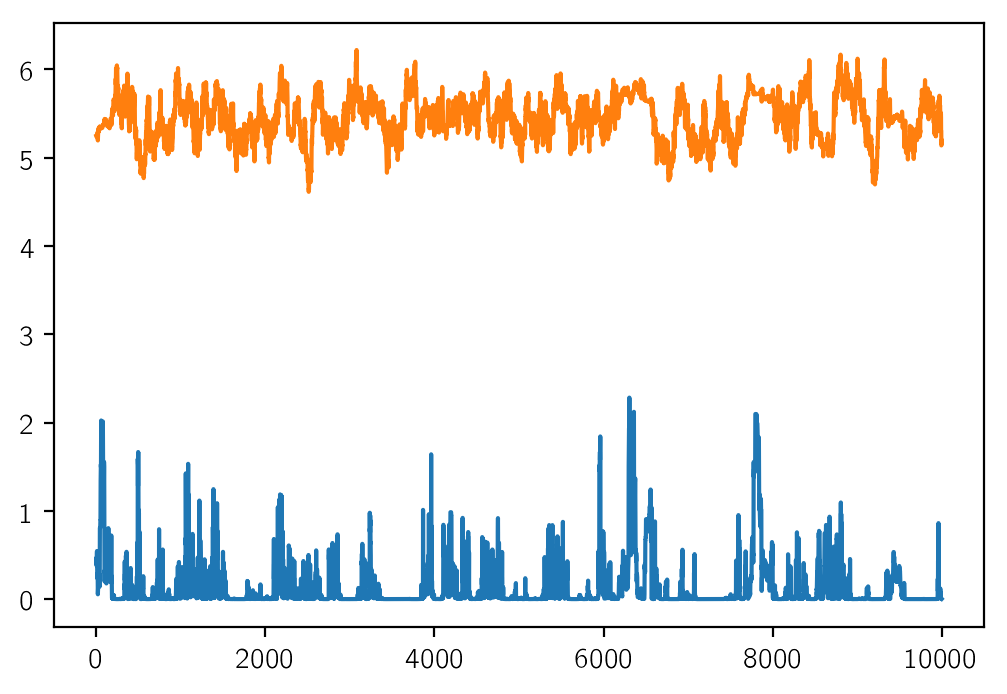

In [14]:
plt.plot(np.exp(tfm.get_value_for_param(chain[:, :N_pl], *log_K.bounds)));

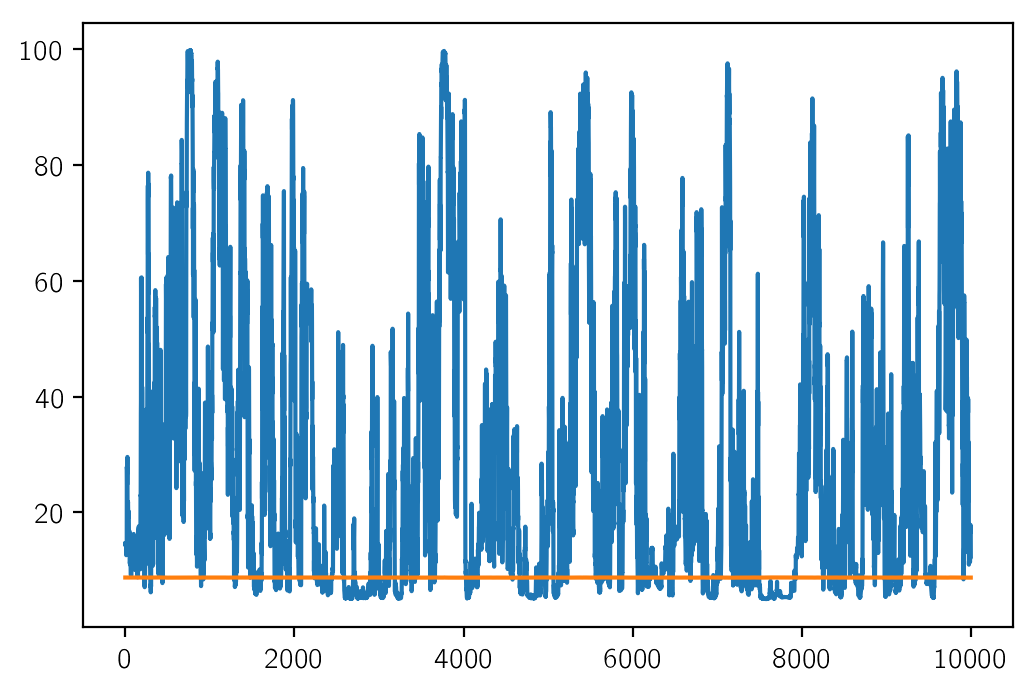

In [15]:
plt.plot(np.exp(tfm.get_value_for_param(chain[:, N_pl:2*N_pl], *log_P.bounds)));

In [16]:
results = model.get_values_for_chain(chain)

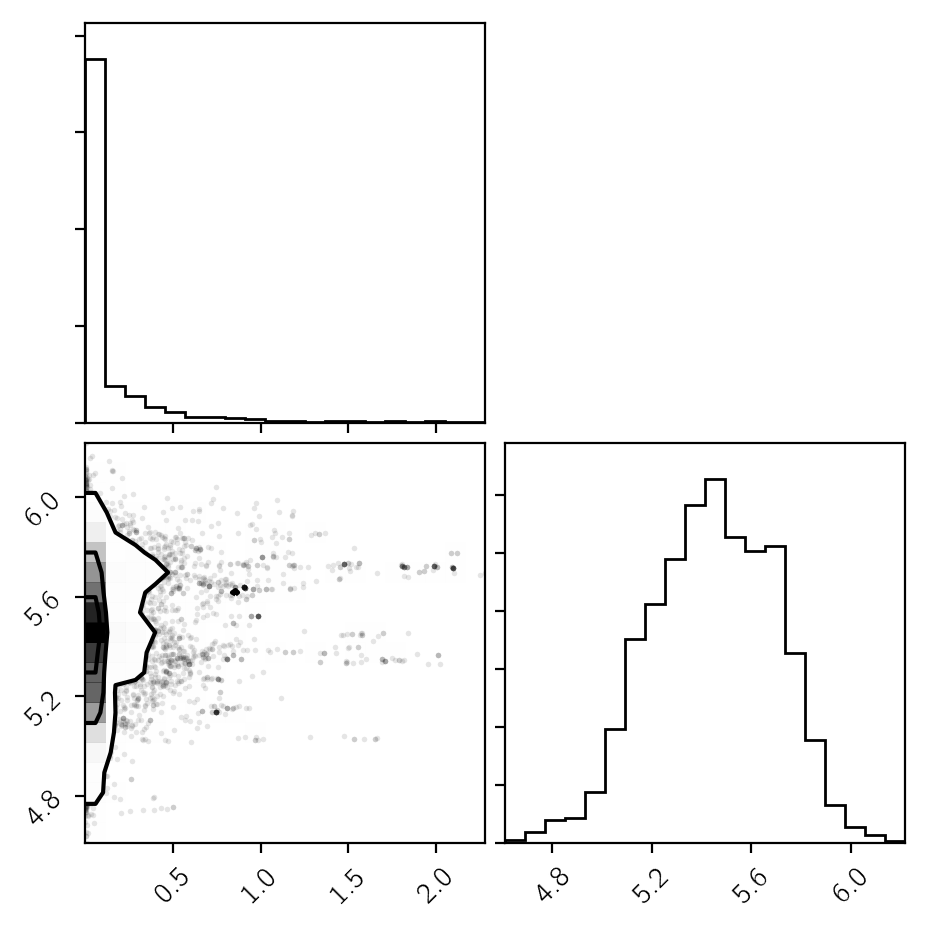

In [17]:
corner.corner(np.exp(results["log_K"]));

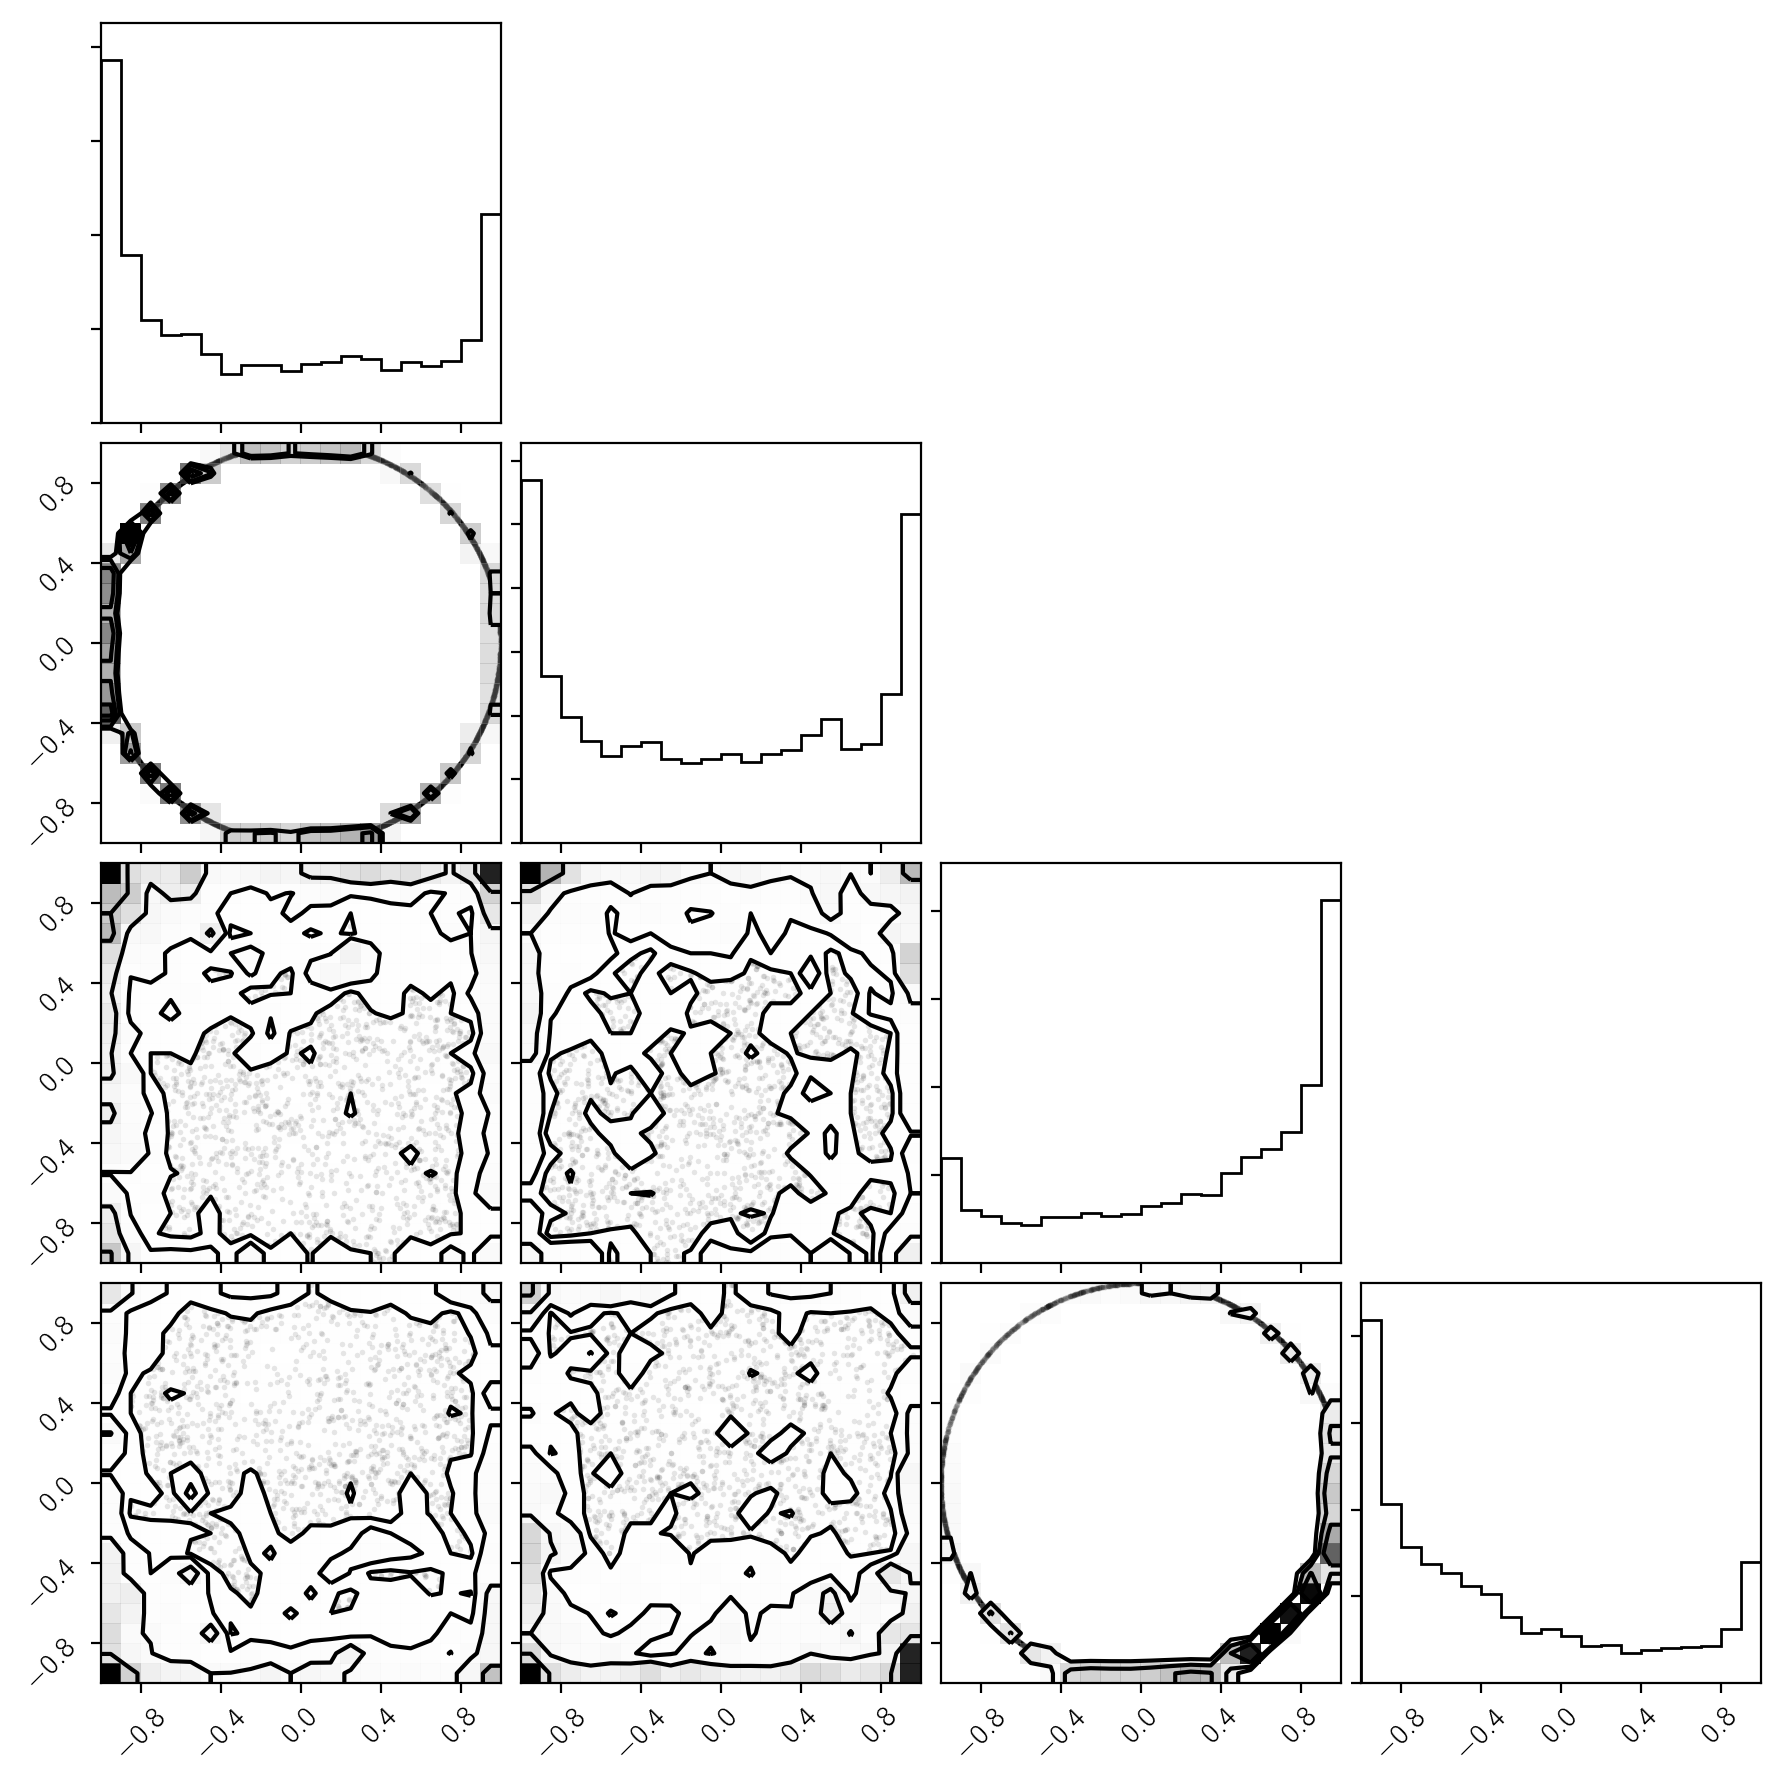

In [18]:
corner.corner(results["omega_vec"].reshape(len(chain), -1));

In [19]:
results2 = model.get_values_for_chain(chain, var_list=[phi, omega], names=["phi", "omega"])

In [20]:
results2

array([([-0.2437319 ,  0.56813649], [-1.75225746,  2.56074134]),
       ([-0.23461557,  0.56676427], [-1.76614252,  2.54619828]),
       ([-0.23802503,  0.56757647], [-1.76258986,  2.56839339]), ...,
       ([ 2.18401661,  0.80760622], [-0.55196071, -0.33674492]),
       ([ 2.33485296,  0.79825777], [-1.28476542, -0.31058575]),
       ([ 2.32765477,  0.77575077], [-2.09856856, -0.08407664])],
      dtype=[('phi', '<f8', (2,)), ('omega', '<f8', (2,))])

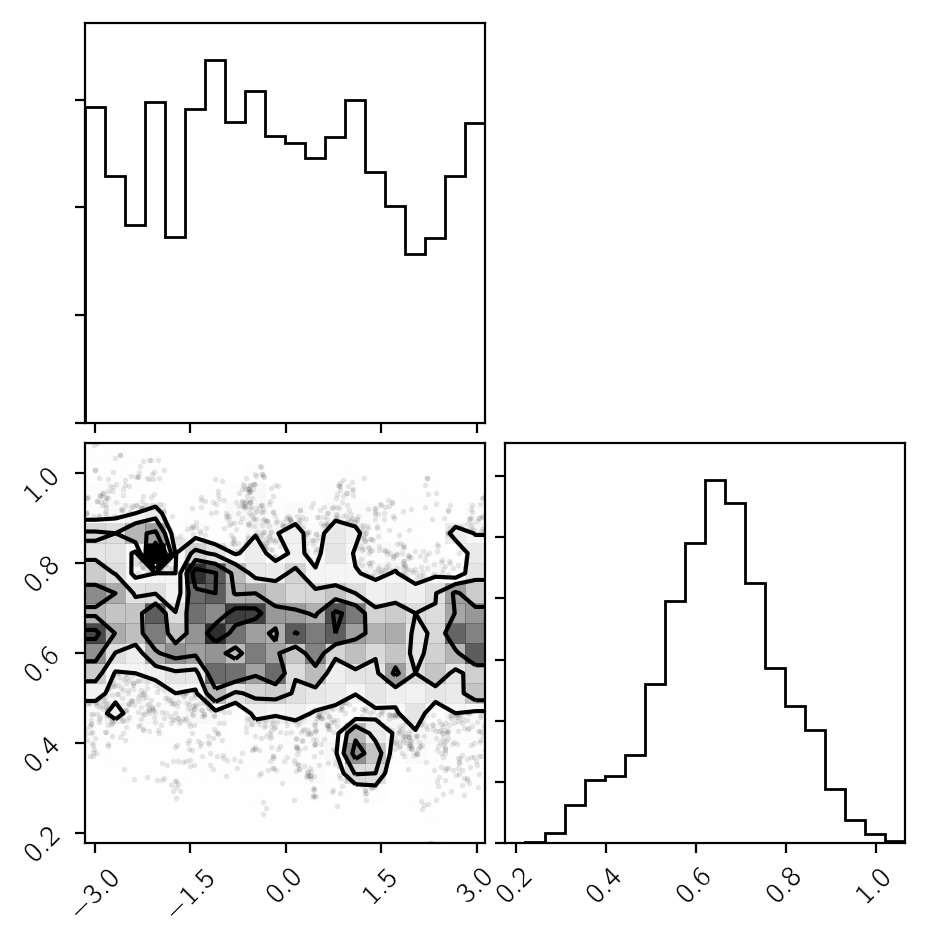

In [21]:
corner.corner(results2["phi"]);

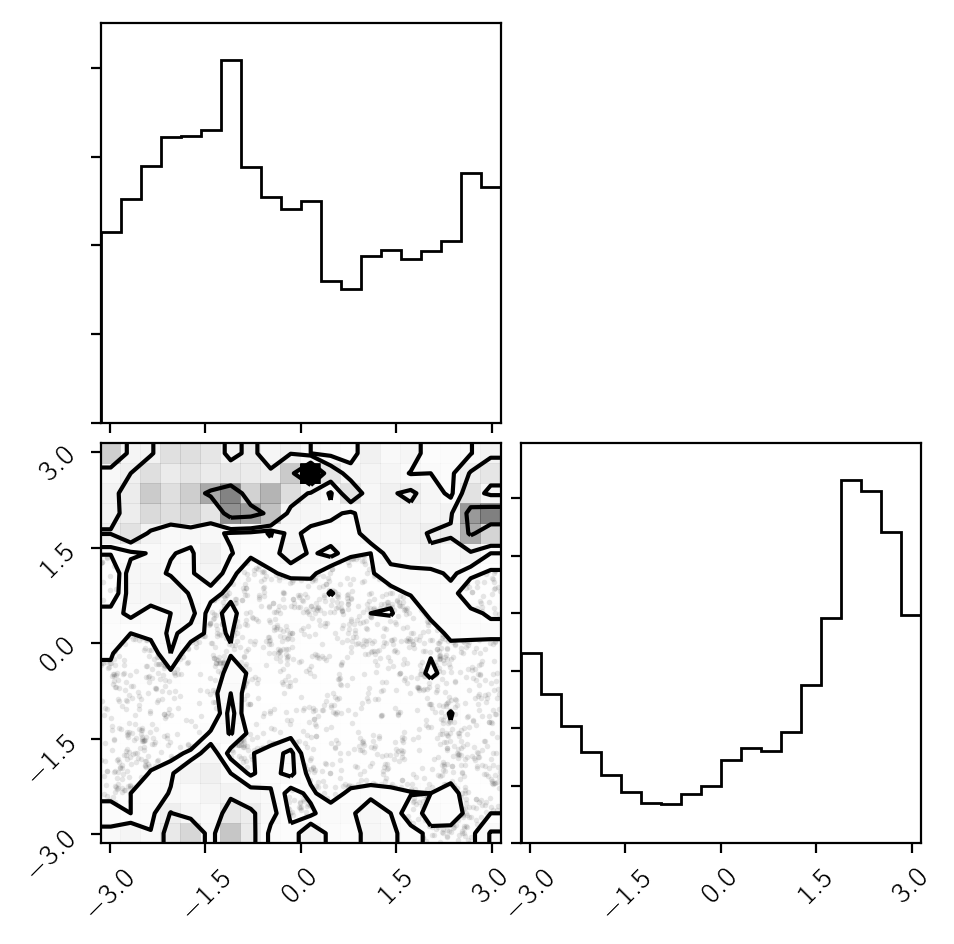

In [22]:
corner.corner(results2["omega"]);